In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, preprocessing
from itertools import product
import statsmodels.api as sm
import warnings
import datetime

warnings.filterwarnings("ignore")

%matplotlib inline

In [47]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);

# подгружаем сохранённые ранее данные для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

In [29]:
# стандартизируем ряды - вычитаем среднее, делим на среднеквадратичное отклонение
df = df.apply(lambda x: (x - x.mean()), raw = True)
df = df.apply(lambda x: x /(x.std()), raw = True)

(-2, 5)

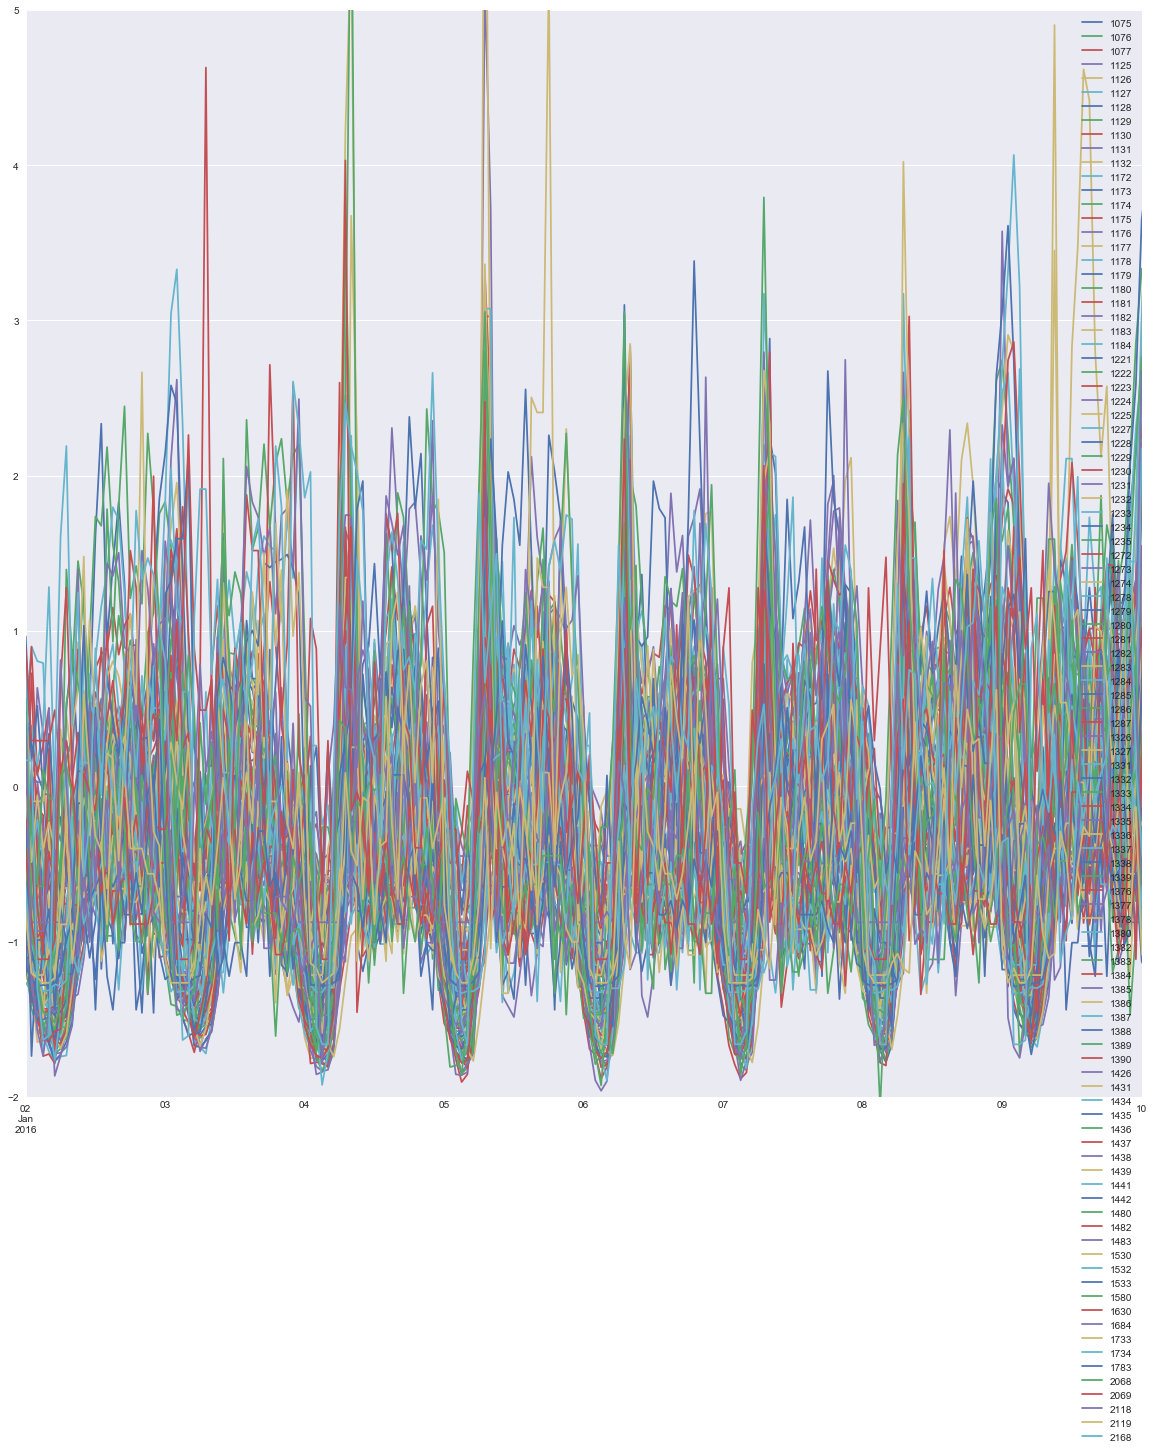

In [7]:
# смотрим что из этого получается
df2.loc['2016-01-02':'2016-01-10',:].plot(figsize = [20,20])
plt.xlim(['2016-01-02','2016-01-10'])
plt.ylim([-2, 5])

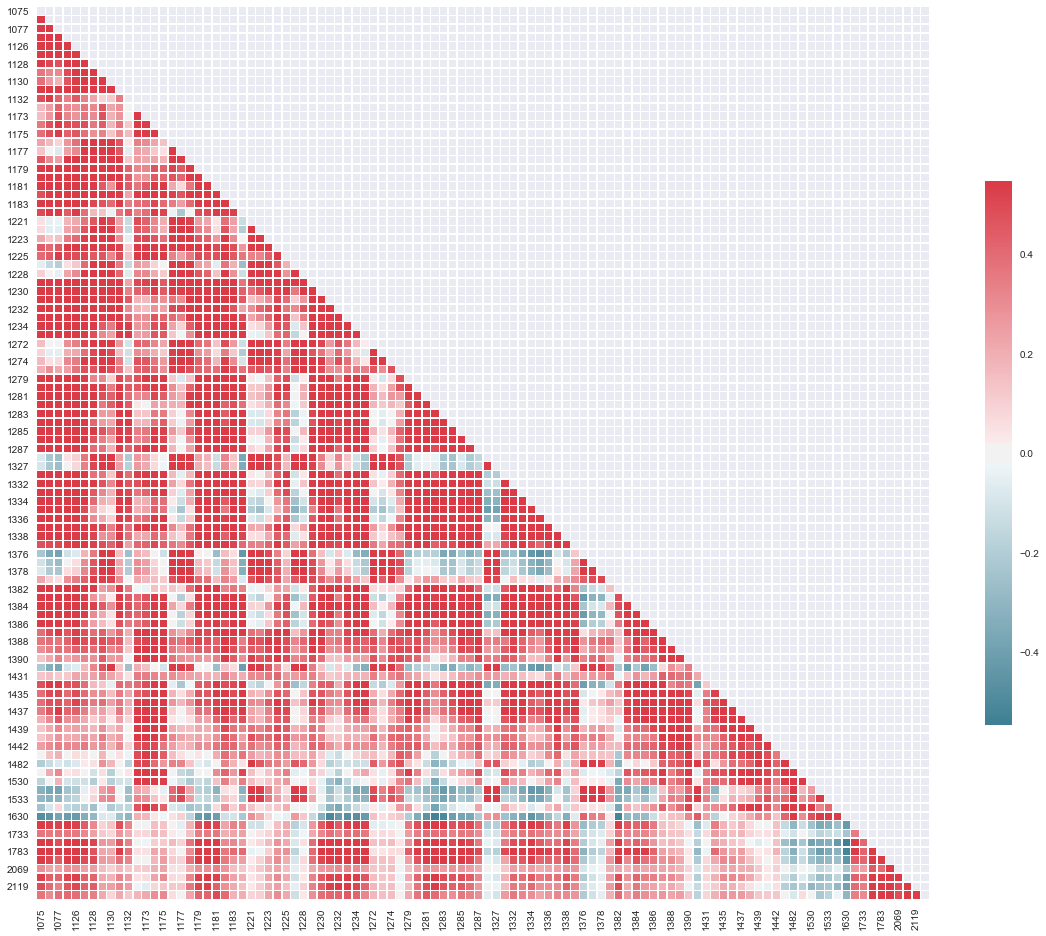

In [8]:
# Вычислим корреляцию рядов для некоторого диапазона дат (1 января 2016 - 31 марта 2016)
s2 = df2.loc['2016-01-01':'2016-03-31',:]
corr = s2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Для разбиения рядов на группы я использовал несколько различных методов группировки:
1) "в лоб" - по значениям рядов
2) по интенсивности Фурье компонен
3) раскладывал ряды по частоте встречающихся значений и группировал их d гистограммы. Потом группировал ряды по полученным гистограммам.

В результате это всё вылилось в несколько огромных блокнотов, содержание которых запутано даже для меня. Поэтому я привожу только конечный результат этой работы. 

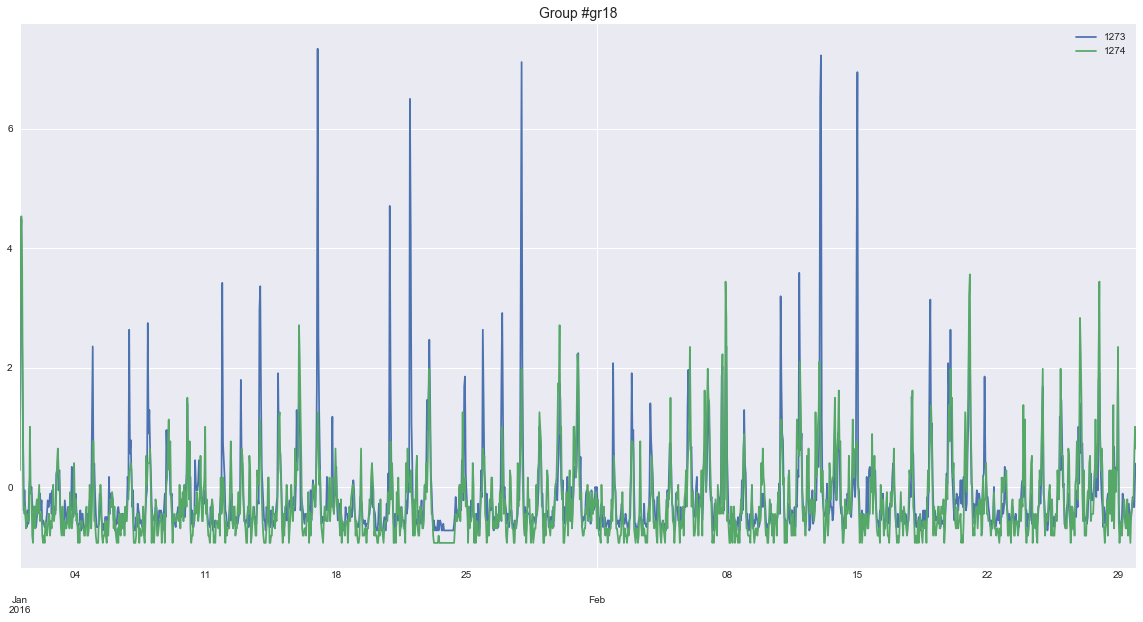

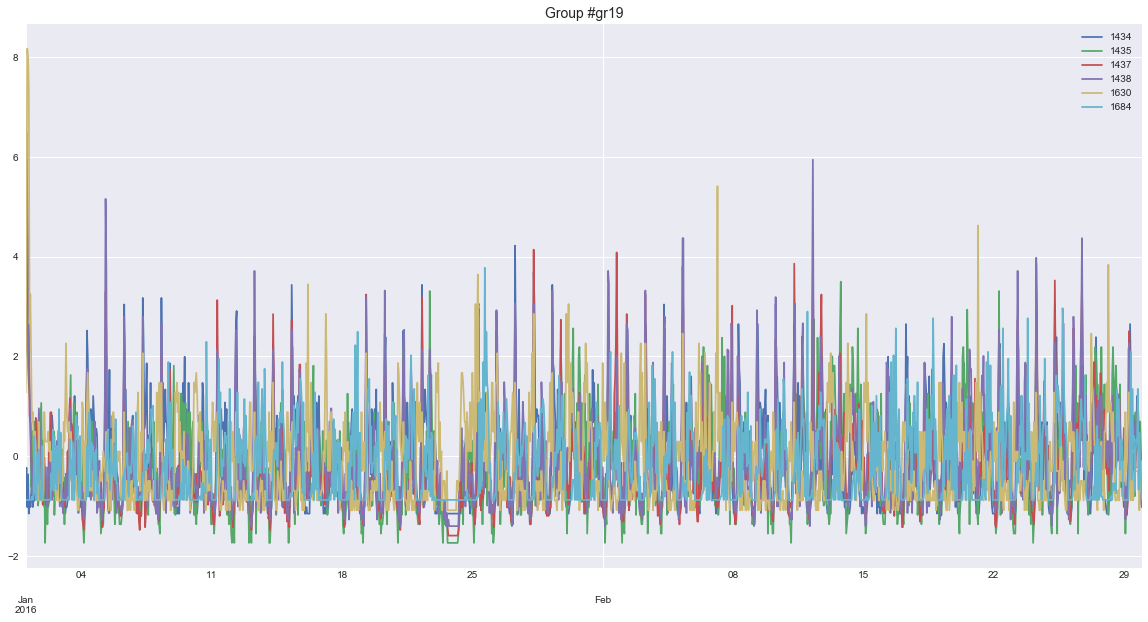

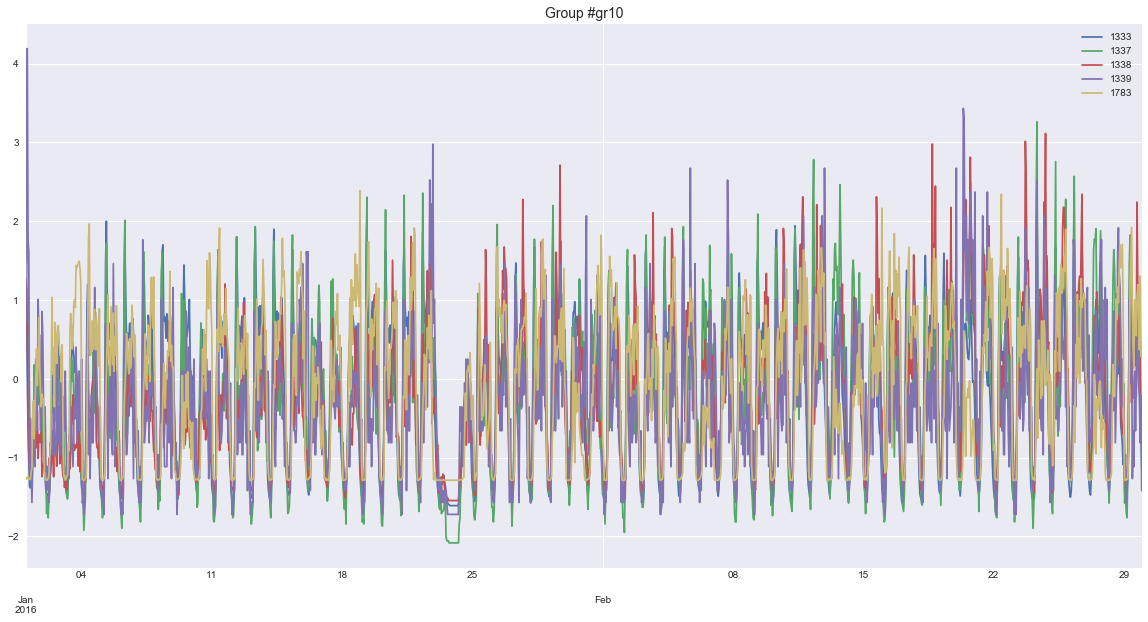

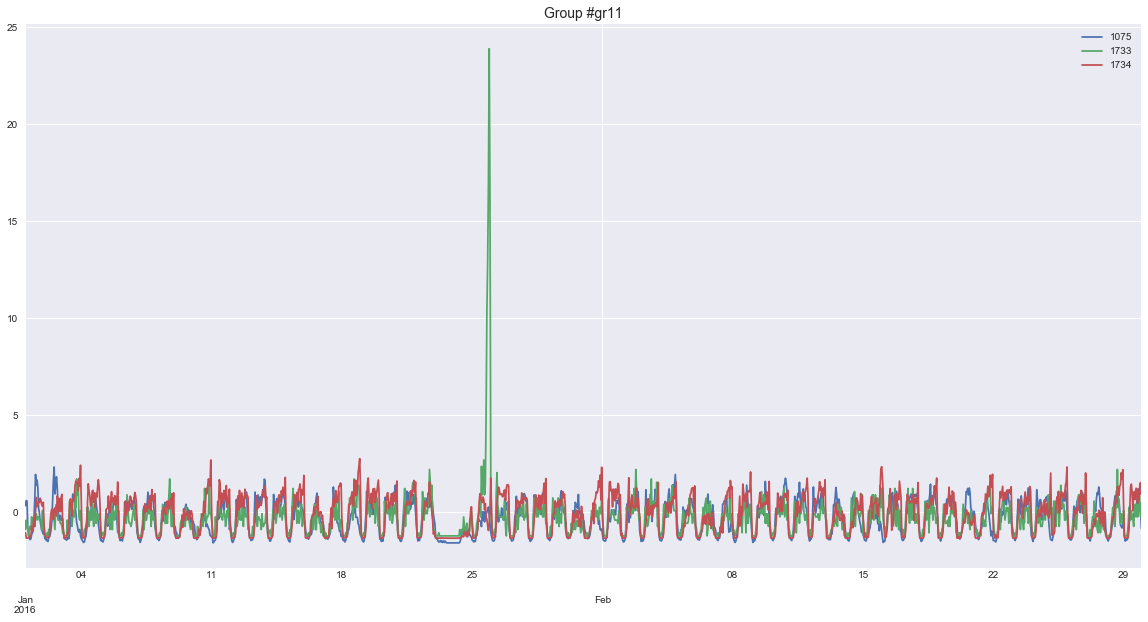

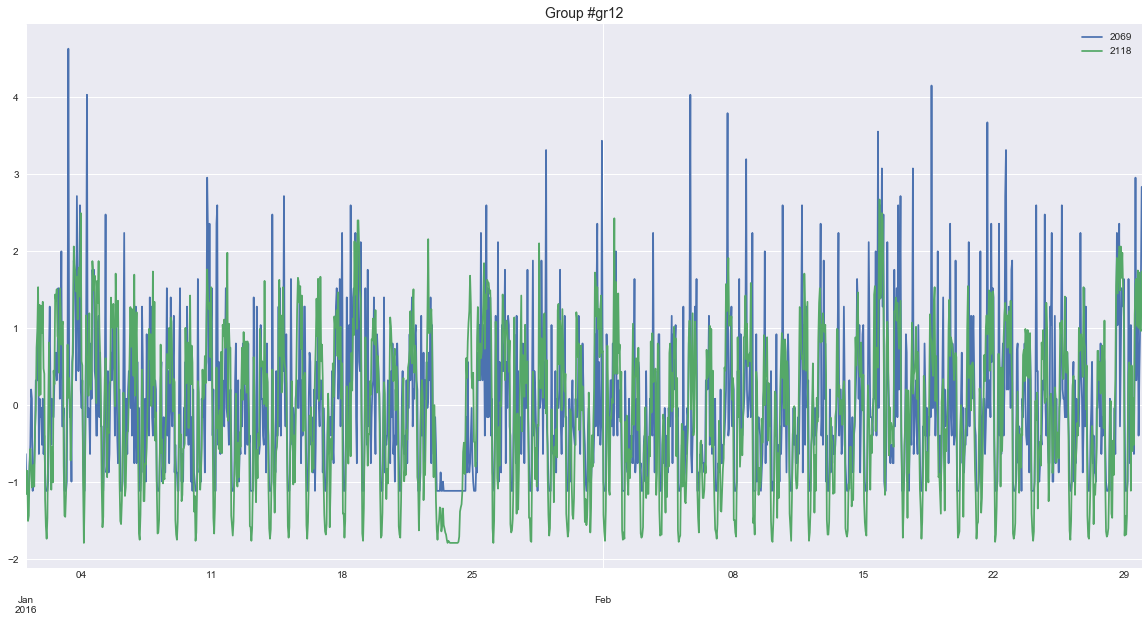

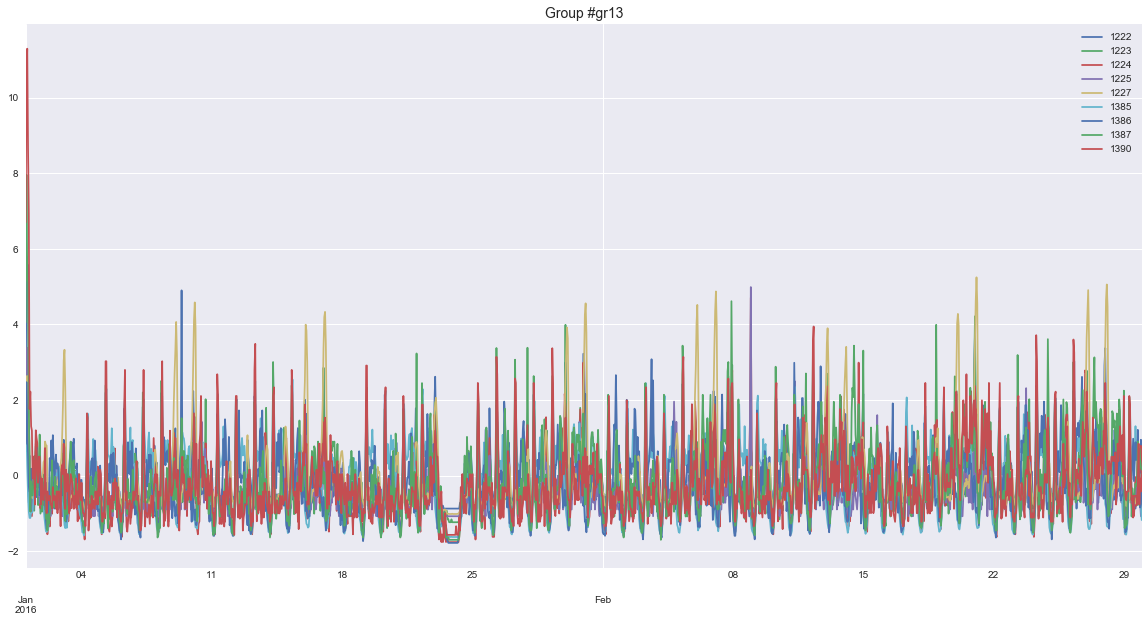

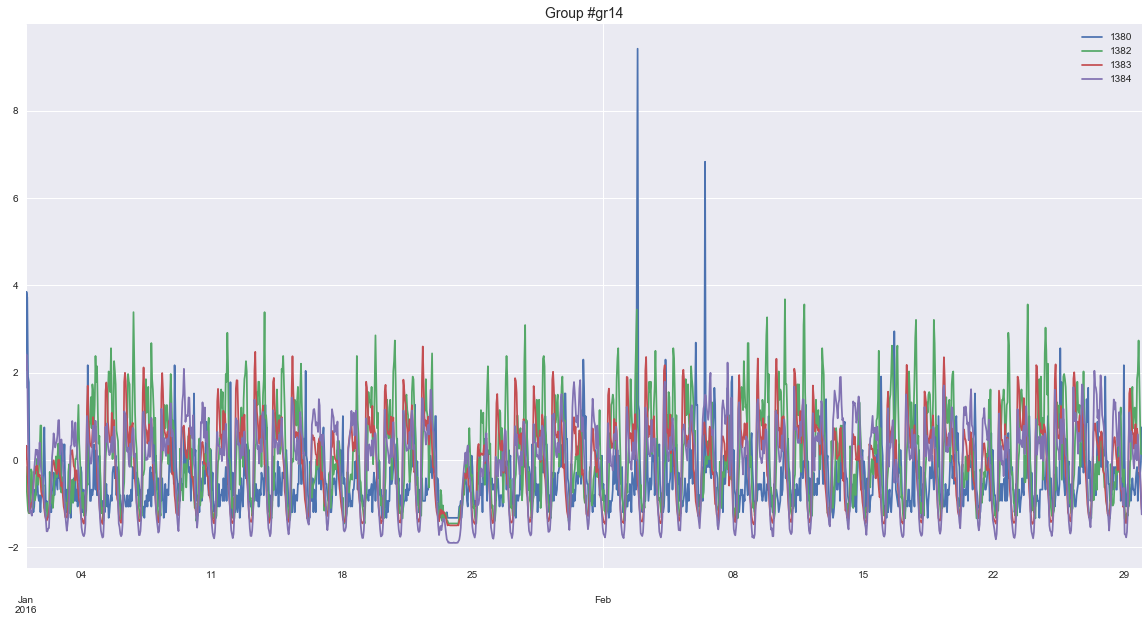

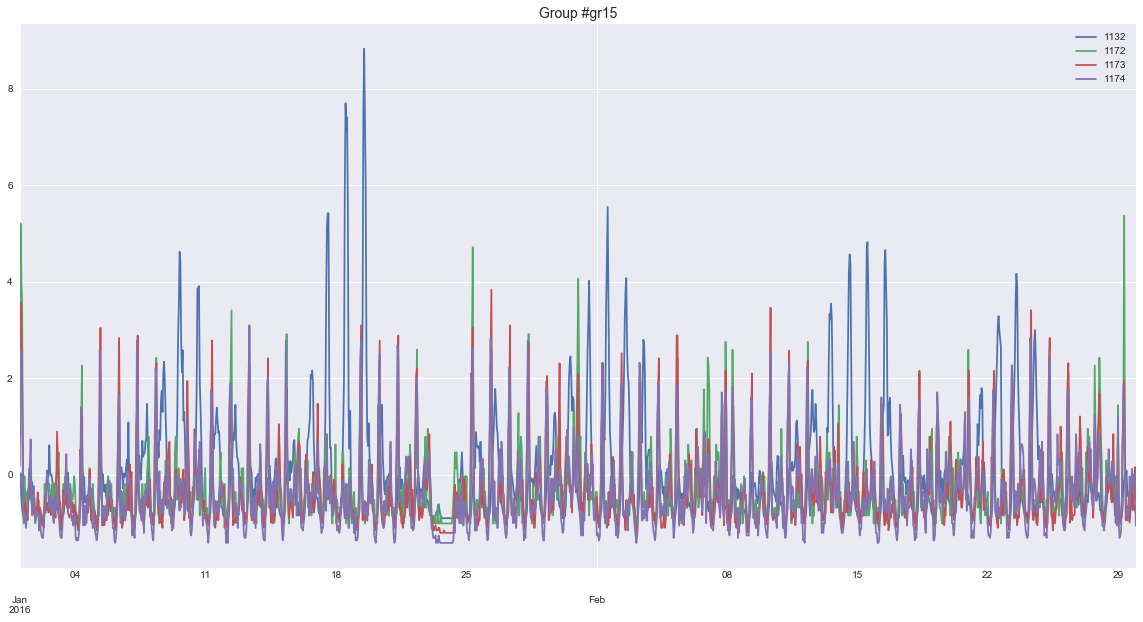

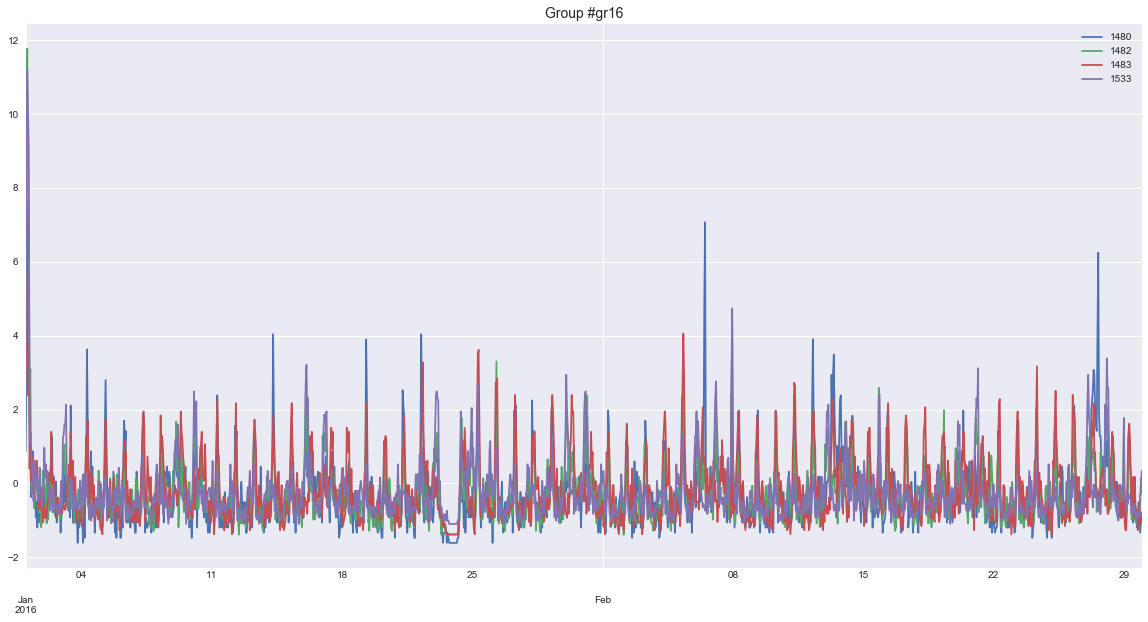

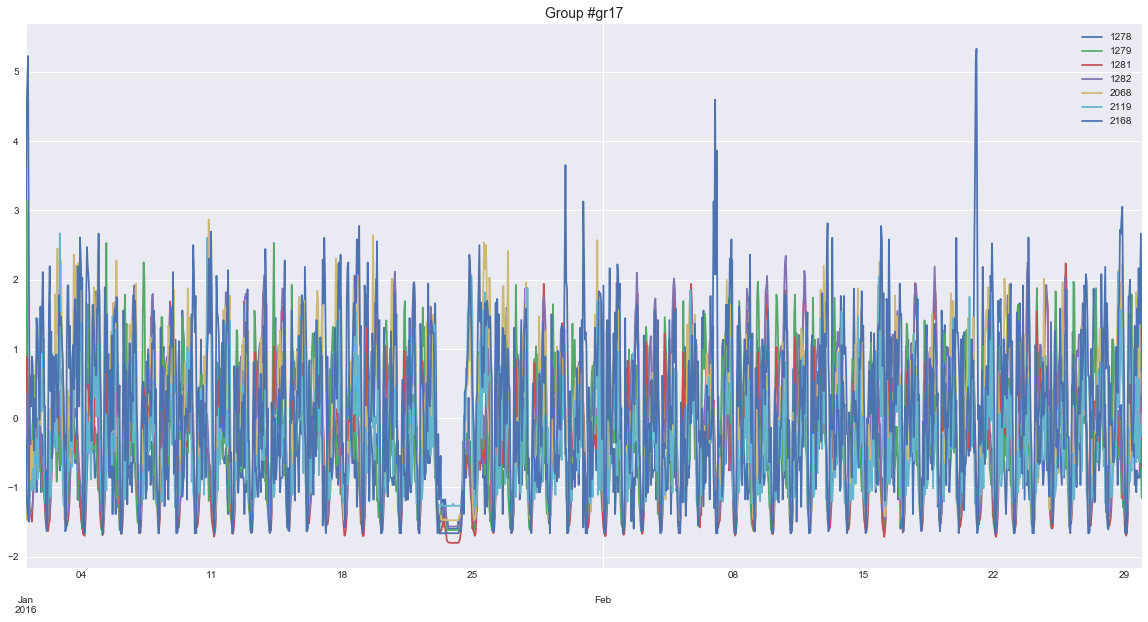

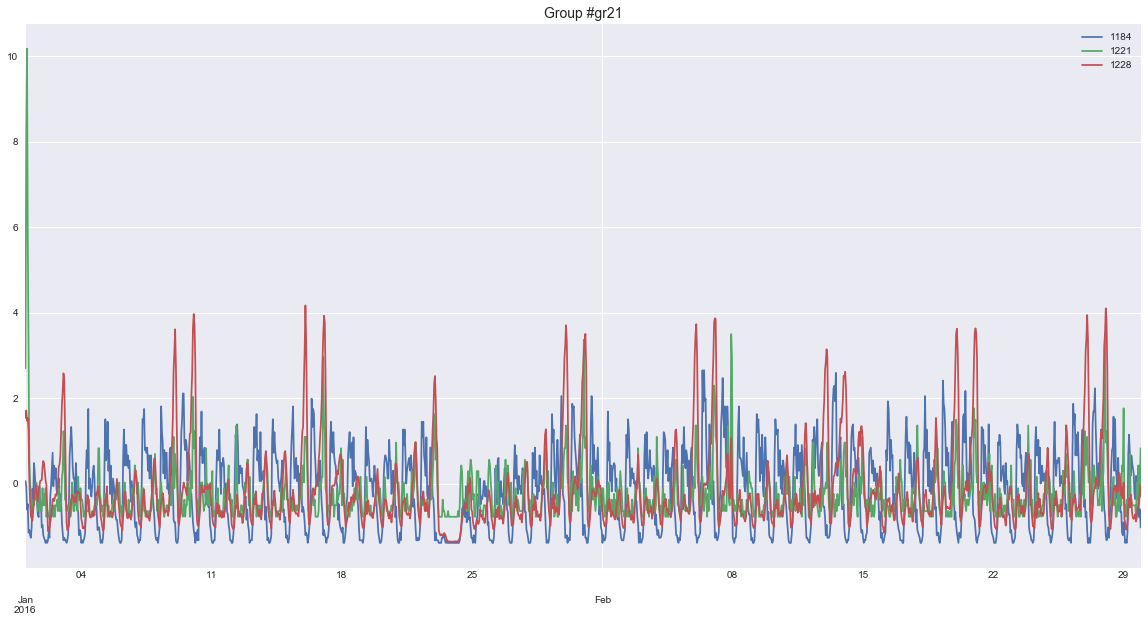

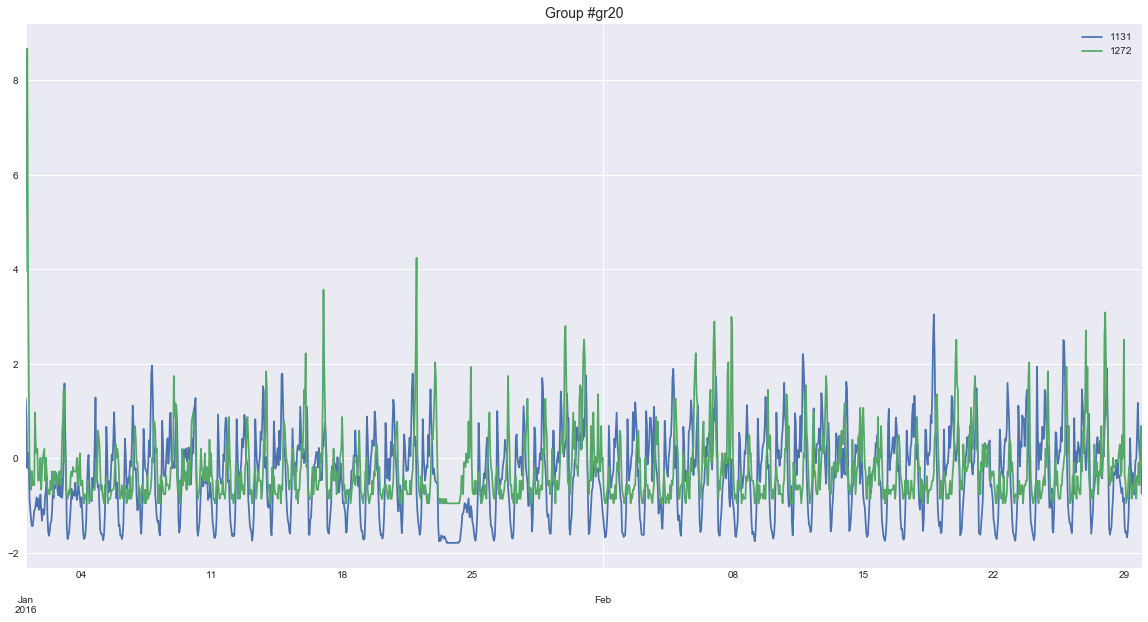

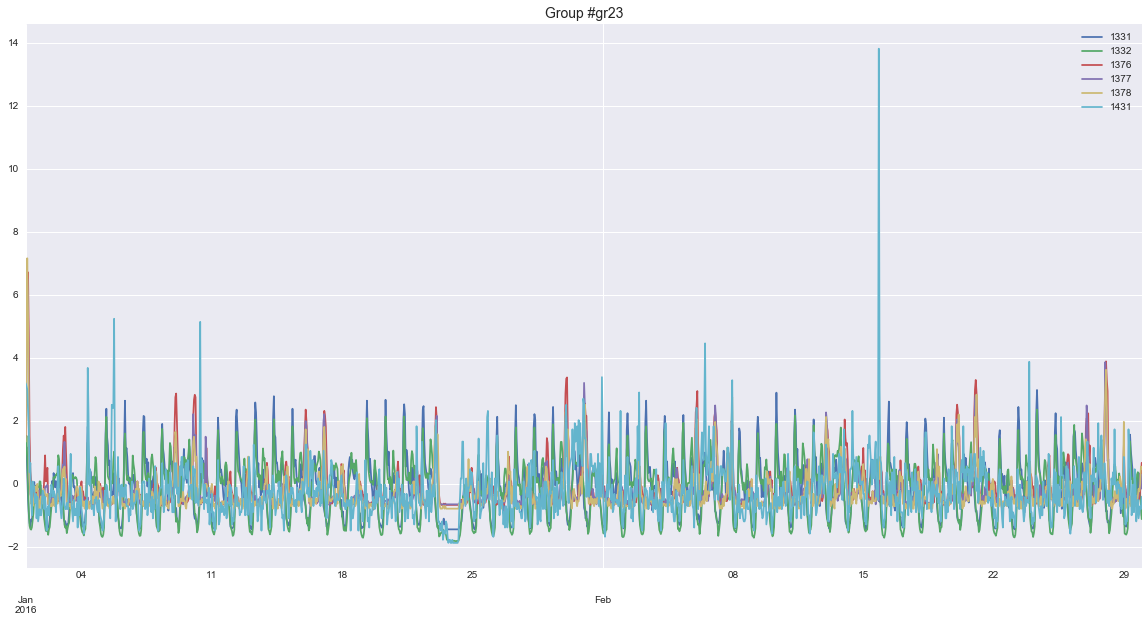

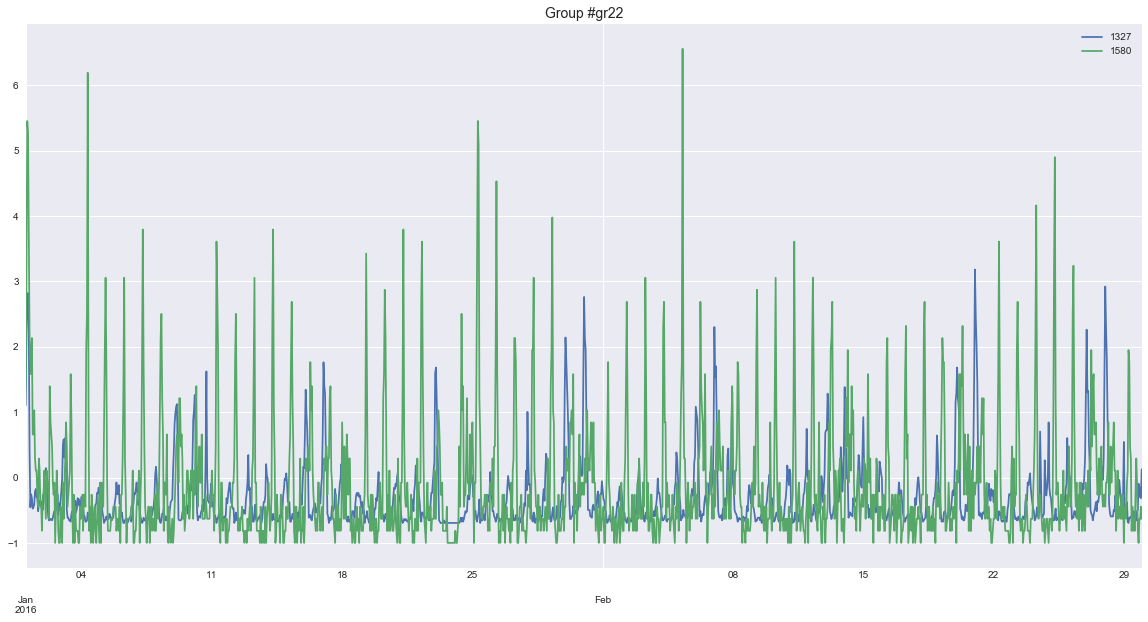

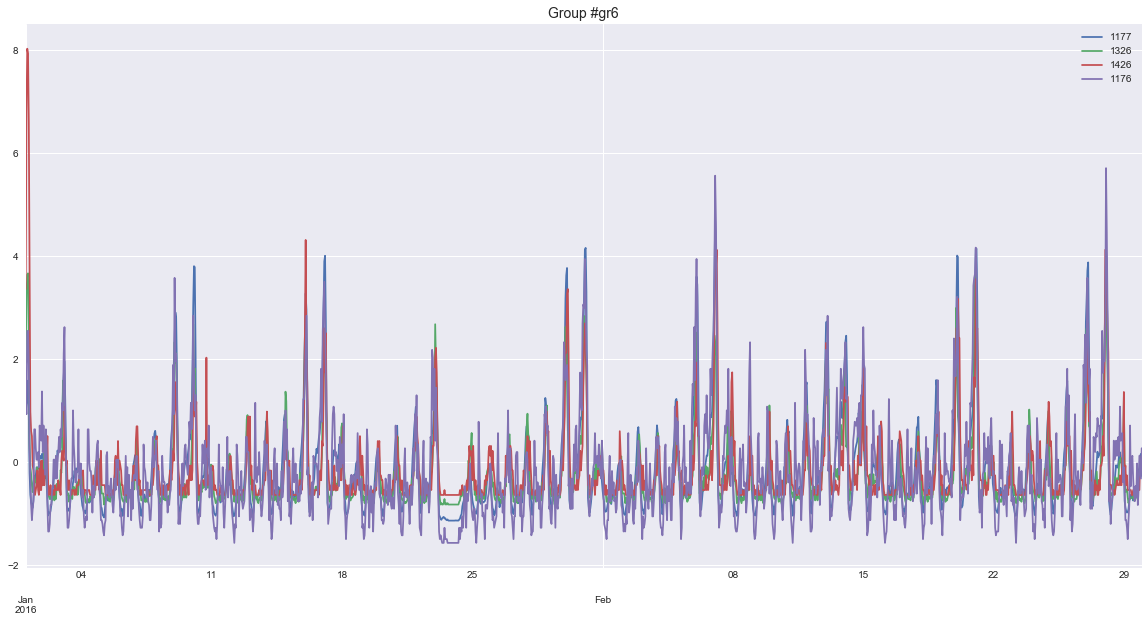

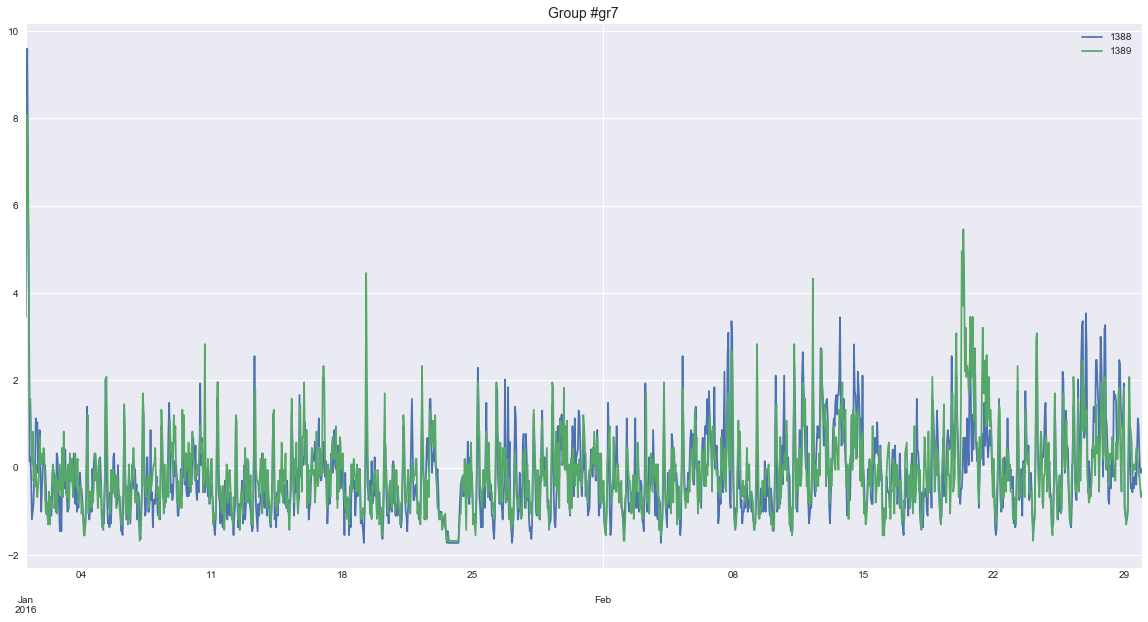

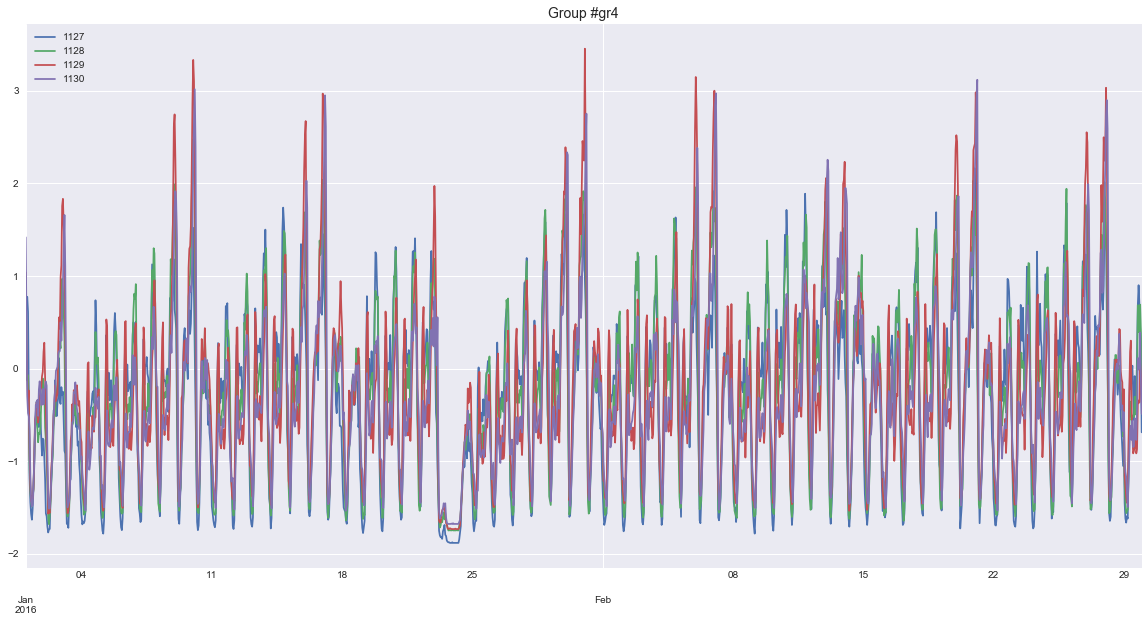

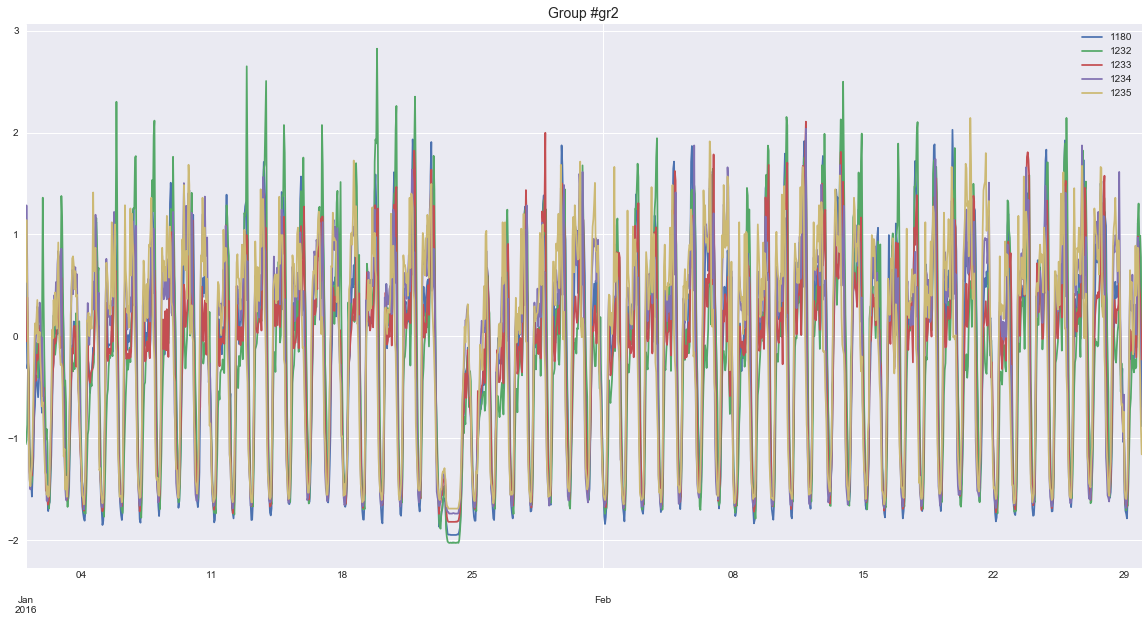

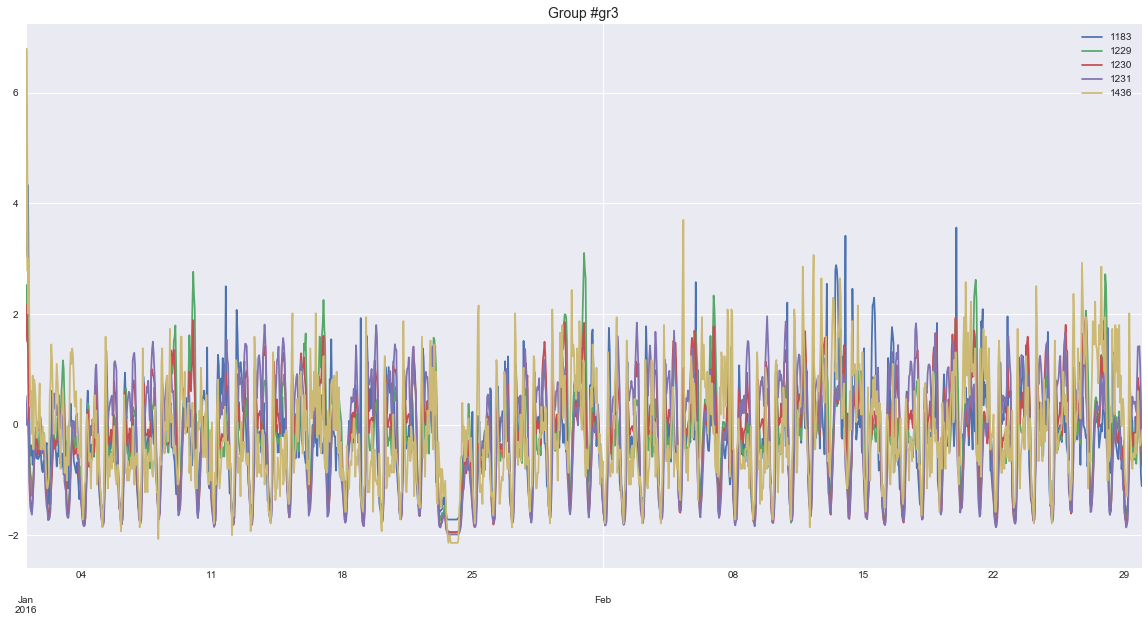

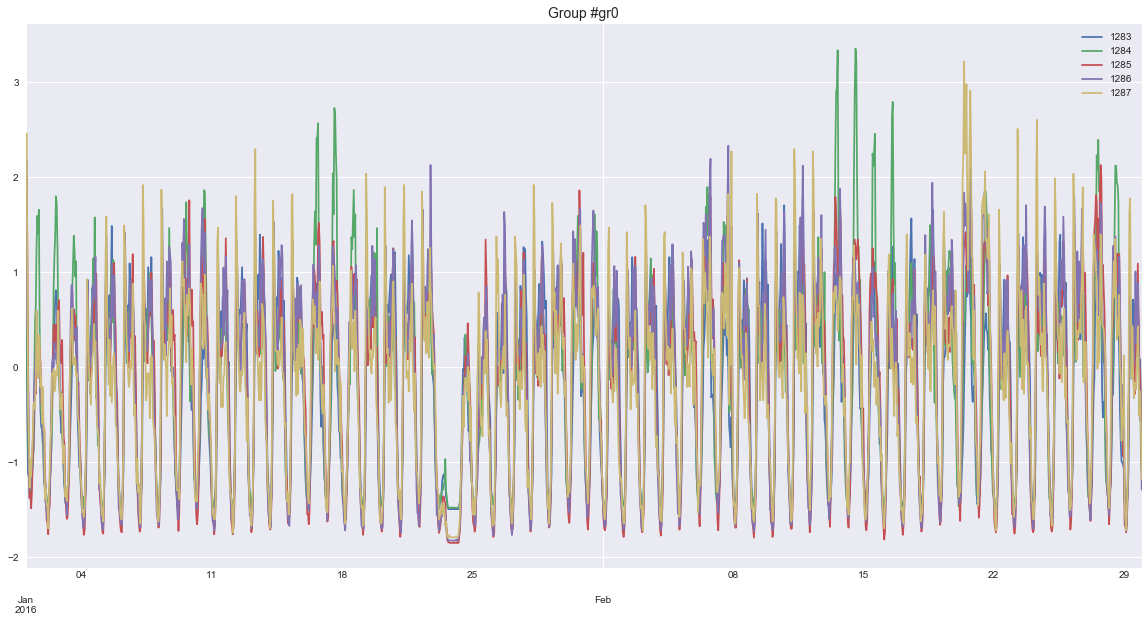

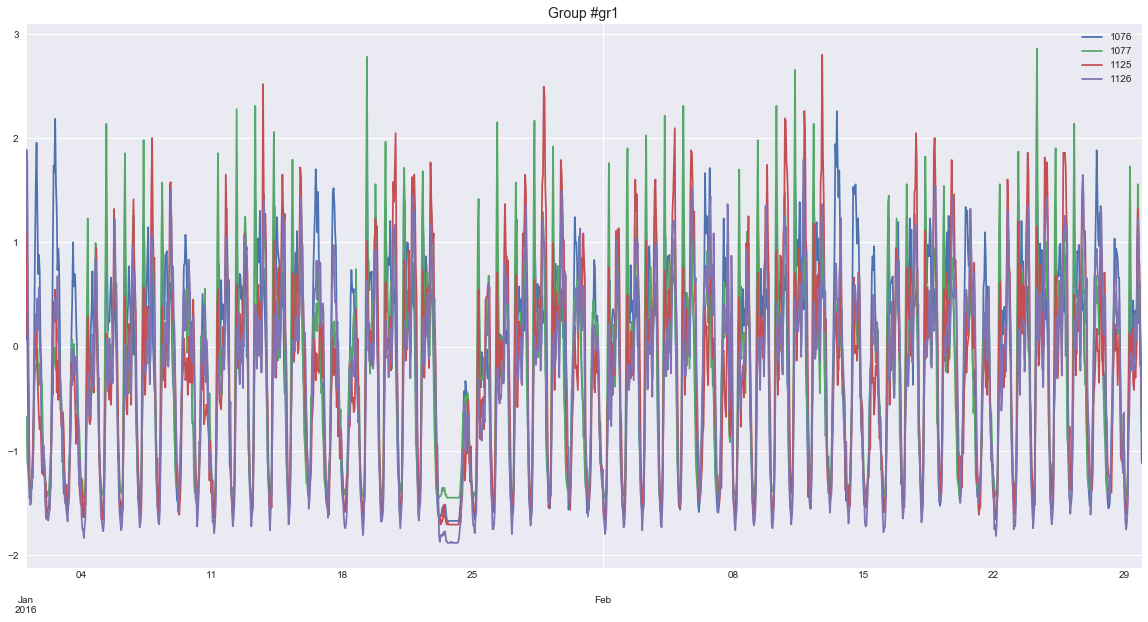

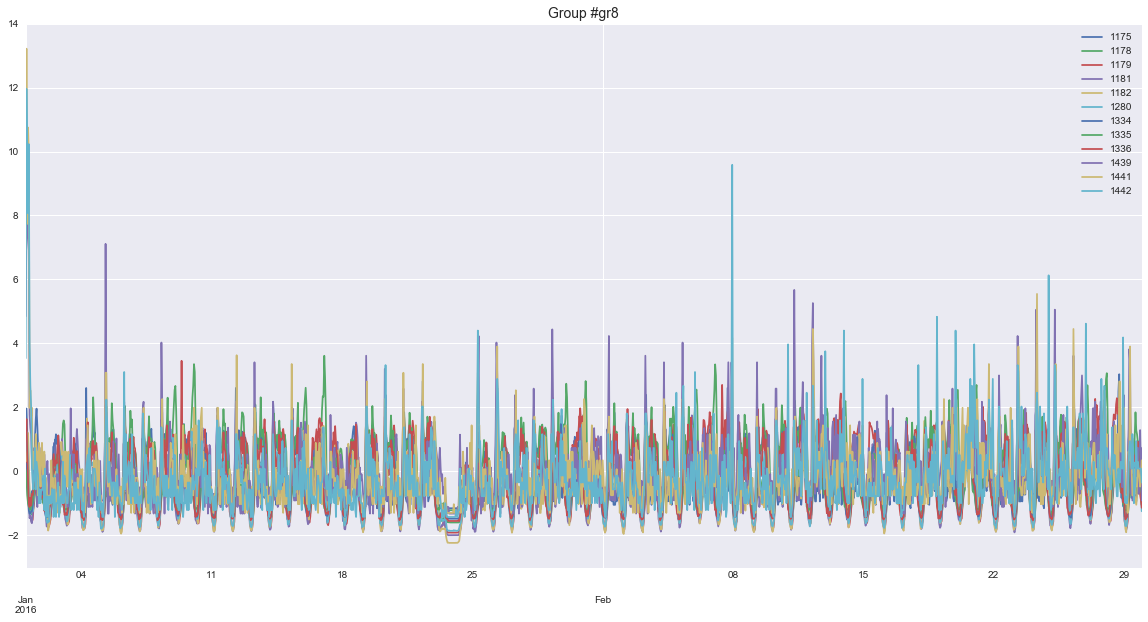

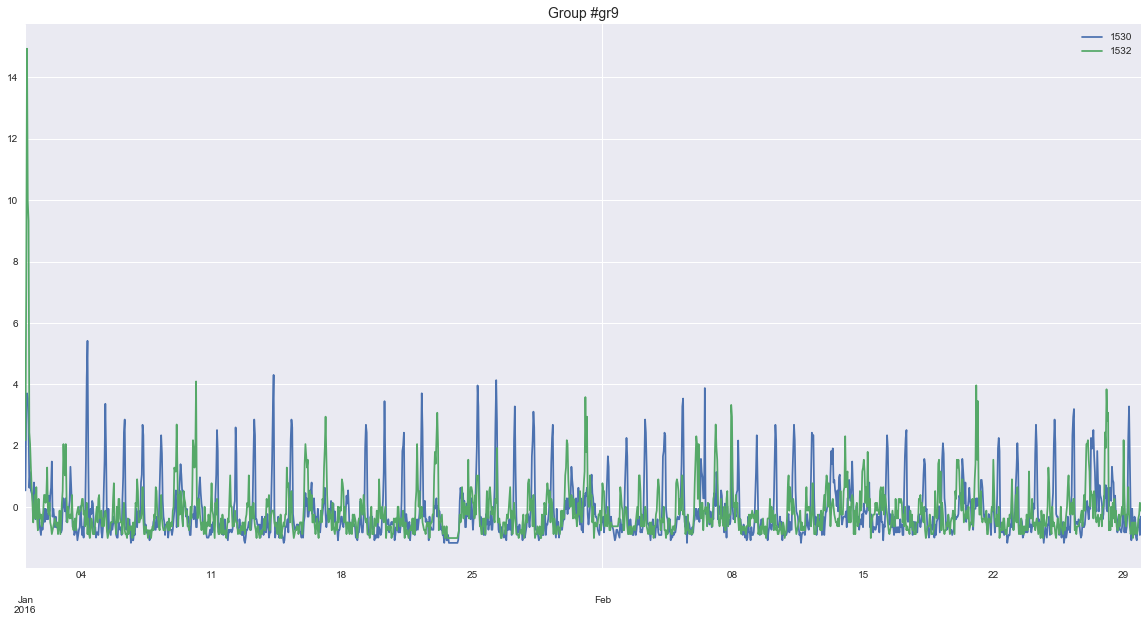

In [11]:
# подгружаем группировку и строим
# словарь с группировкой рядов
tsGroups = np.load('tsGroups.npy').item()

def plotGroups(ts,grs):
    for (k, v) in grs.iteritems():
        plt.figure()
        ts.loc['2016-01':'2016-02',v].plot(figsize=[20,10])
        plt.title('Group #'+str(k), fontsize = 14)
        
        
plotGroups(df2,tsGroups)        

Теперь задам вручную ряды, на которых будут подбираться параметры SARIMAX моделей

In [12]:
# выберу настроечные ряды руками
fitSeries = {'gr18':'1274','gr19':'1684','gr10':'1333','gr11':'1075','gr12':'2118','gr13':'1387','gr14':'1384','gr15':'1174'}
fitSeries.update({'gr16':'1483','gr17':'1282','gr21':'1184','gr20':'1131','gr23':'1332','gr22':'1580','gr6':'1177','gr7':'1388'})
fitSeries.update({'gr4':'1128','gr2':'1234','gr3':'1231','gr0':'1286','gr1':'1125','gr8':'1181','gr9':'1532'})

Теперь запишем набор функций, который будут использованы дальше

In [23]:
def addFeatures(res, Kw = 6, Ka = 3):    
    """verbose
    Функция добавляет новые features к временному ряду
    params:
        res - pandas dateRange
        Kw, Ka - количество недельных и годовых гармоник
    """
    
    # add linear feature
    res = res.assign(hours = (res.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(res.index.dayofweek),columns = ['DayOfWeek_'+str(x) for x in np.arange(6)],
                       index = res.index)      
    res = res.merge(DoW,left_index=True,right_index=True)
 
    # добавляем dummy variables для месяца
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(res.index.month),columns = ['Month_'+str(x) for x in np.arange(12)],index = res.index)      
    res = res.merge(Months,left_index=True,right_index=True);
    return res

In [36]:
# Регрессор
def regression(res, alpha = 0.1, plot = False,verbose = False, searchBestFit = False):
    """
    Функция регрессионного анализа временного ряда
    params:
        res - временной ряд
        aplha - параметр регрессора
        plot - включает позволяющая отобразить исходные данные, фит и остатки
        verbose - включает детальный вывод информации об аппроксимации
        searchBestFit - включает подбор гиперпараметров регрессора
    return
        - предсказанное значение ряда
        - остатки
        - регрессор (объект)
    """
    X = res.drop('trip_count',axis = 1)        
    y = res.loc[:,'trip_count'];
    
    if searchBestFit:
        # создать словарь параметров
        param_grid = {'alpha': [x for x in np.linspace(10,100,10)]} #,'l1_ratio': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1]}
        # создать кросс-валидацию для временных рядов
        tscv = model_selection.TimeSeriesSplit()
        
        # запустить поиск оптимальных параметров
        regressor = linear_model.Ridge()
        clf = model_selection.GridSearchCV(regressor, param_grid, n_jobs=4, cv=tscv, verbose=1)
        clf.fit(X,y)
        regressor = clf.best_estimator_        
        print 'Best params is', clf.best_params_ 
        
        
    else:
        regressor = linear_model.Lasso(alpha = alpha, max_iter = 1e5,fit_intercept = True,random_state = 0);
        regressor.fit(X,y)
        
    y_pr = pd.Series(data = regressor.predict(X), index = res.index)
    R = regressor.score(X,y);
    print 'R factor is ', R
    
    if plot:
        plt.figure(figsize = [15,10])
        plt.subplot(211)
        plt.plot(y)
        plt.plot(y_pr)
        plt.legend(['Original data','Predicted'])

        plt.subplot(212)
        plt.plot(y-y_pr)
        plt.legend(['Residuals'])
        
    return [y_pr, y-y_pr, regressor]

In [38]:
def getRegressor(regressor, start_date = '2016-05-15 00:00:00', end_date = '2016-05-20 23:00:00'):
    """
    Функция предсказания значения ряда на основе настроенного ранее регрессора
    params:
        regressor - объект регрессора, полученной из предыдущей функции
        start_date, end_date - даты начала и конца предсказаний
    return
        - временной ряд (pandas.TimeSeries)
    """
    predictionStart = datetime.datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')
    predictionEnd = datetime.datetime.strptime(end_date,'%Y-%m-%d %H:%M:%S')
    date_index = pd.date_range(predictionStart, predictionEnd, freq='H')
   
    #какой-то пипец. Должен быть способ сделать это проще.
    features = date_index.to_series().to_frame()
    features = addFeatures(features)
    features = features.drop(0,axis = 1)
    exog = regressor.predict(features)
    return pd.Series(exog,index = date_index)

In [28]:
def findHyperParams(ts,pList = []):
    """
    Поиск оптимальных параметров SARIMAX модели
    params:
        ts - временной ряд
        pList - набор параметров для перебора (не обязательный параметр)
    return
        - значение параметра Акаике для оптимальной модели
        - список [p, q, Ps, Qs] значений оптимальных параметров
    """
    
    if (len(pList) ==0):
        # create list of parameters
        ps = range(2, 7)
        d  = 1
        qs = range(2, 7)

        Ps = range(1, 3)
        D  = 1
        Qs = range(1, 3)

        pList = list(product(ps, qs, Ps, Qs))
    
    results = []
    best_aic = float("inf")
    
    # add features
    ts = addFeatures(ts, Kw = 6, Ka = 3)
    # regression
    [s, r, lasso] = regression(ts,verbose = True, searchBestFit = True)
    
    # loop over parameters' list
    for param in pList:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        print('Parameters:', param)
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(ts.loc[:,'trip_count'], order=[param[0], 1, param[1]],
                                          seasonal_order=(param[2], 1, param[3], 24),exog = r).fit(disp=1);
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except Exception as inst:
            print inst           # __str__ allows args to be printed directly
            continue
        else:     
            aic = mSARIMA.aic
            print('AIC',aic) 
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                best_model = mSARIMA
                best_aic = aic
                best_param = param
            results.append([param, mSARIMA.aic])
    return [best_aic,best_param]

Теперь проходим по всем группам временных рядов и подбираем параметры SARIMAX модели. Результаты сохраняем в файл.


In [ ]:
warnings.filterwarnings('ignore')
paramsDict = {}

for grName, tsName in fitSeries.iteritems():
    
    print 'New groups'
    print grName, tsName
    
    [aic, best_param] = findHyperParams(df.loc[startDate:endDate,tsName].to_frame(name = 'trip_count'),parameters_list)
    
    paramsGroups.update({grName: [aic, best_param]})
    print paramsGroups
    
warnings.filterwarnings('default')
np.save('paramsGroups.npy', paramsGroups)

Теперь проходим по всем рядам, обучаем модели, делаем предсказания на май 2016 и считаем ошибку.

In [48]:
# диапазон дат для обучения
startFit = '2016-01-01 0:0:0'
endFit = '2016-04-30 23:00:00'
resFile = 'predictionResults-May2016.pcl'
err = 0

# диапазон дат для предсказания
startPrediction = '2016-05-01 00:00:00'
endPrediction = '2016-05-31 23:00:00'
predictionRange = pd.date_range(startPrediction, endPrediction, freq='H')

paramsGroups = np.load('paramsGroups.npy').item()

# create array to save prediction results
mIndex = pd.MultiIndex.from_product([df.columns.values, predictionRange])
resDf = pd.DataFrame(index = mIndex, columns = ['y','err'])

for grId, ts in tsGroups.iteritems():
    print 'Group ID is', grId
    
    # получаем параметры SARIMAX модели
    params = paramsGroups.get(grId)[1] 
    
    for tsId in ts:
        print 'Regions is ', tsId
        # получаем временной ряд
        ts = df.loc[startFit:endFit,tsId] #

        # обучаем регрессор
        ts = ts.to_frame(name = 'trip_count')
        [r_pr, res, regressor] = regression(addFeatures(ts),searchBestFit = True)

        # обучаем SARIMAX модель
        print 'Learn SARIMAX'
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(ts, order=[params[0], 2, params[1]],
                                              seasonal_order=(params[2], 1, params[3], 24),
                                              exog = r_pr, enforce_invertibility = True).fit(disp=1);
        except Exception as inst:
            print type(inst)     
            print inst          

        # получаем предсказания регрессора на весь диапазон дат (обучение+предсказание)
        exog = getRegressor(regressor,startFit,endPrediction)
        # получаем данные о поездкахы на весь диапазон дат
        endog = df.loc[startFit:endPrediction,tsId]
       
        # создаём новую модель, которую будет использовать для предсказания
        # Для чего такой финт ушами - не понимаю до сих пор
        try:
            model_fitted = sm.tsa.statespace.SARIMAX(endog, order=[params[0], 1, params[1]],
                                                 seasonal_order=(params[2], 1, params[3], 24),
                                                 exog = exog).filter(mSARIMA.params)
        except Exception as inst:
            print 'Can not create the model'
            print inst
            continue
            
        # проходим по всему диапазону дат предсказаний
        print 'Make prediction'
        for firstLag in predictionRange[:-5]:
            lastLag = firstLag+datetime.timedelta(hours = 5)
            # prediction
            try:
                predicted_data = model_fitted.predict(firstLag, lastLag, dynamic=True, exog = exog[firstLag:lastLag])
            except Exception as inst:
                print 'Prediction error'
                print inst
            else:
                # save results
                resDf.loc[tsId,firstLag].y = predicted_data
                err += (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().sum()
                resDf.loc[tsId,firstLag].err = (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().mean()
                    
    # save results
    resDf.to_pickle(resFile)
    
print 'Total error is', err    

Group ID is gr18
Regions is  1273
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0384105018608
Learn SARIMAX
Make prediction
Regions is  1274
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.0955607434377
Learn SARIMAX
Make prediction
Group ID is gr19
Regions is  1434
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0244458572794
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1435
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.112911775993
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1437
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0903492862207
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1438
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.053713937324
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1630
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0790515125439
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1684
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 70.0}
R factor is  0.12215583504
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Group ID is gr10
Regions is  1333
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0351639426859
Learn SARIMAX
Make prediction
Regions is  1337
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0831633215292
Learn SARIMAX
Make prediction
Regions is  1338
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 10.0}
R factor is  0.13404741713
Learn SARIMAX
Make prediction
Regions is  1339
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 30.0}
R factor is  0.0708030978936
Learn SARIMAX
Make prediction
Regions is  1783
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.135192119887
Learn SARIMAX
Make prediction
Group ID is gr11
Regions is  1075
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0745996919203
Learn SARIMAX
Make prediction
Regions is  1733
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0585453412026
Learn SARIMAX
Make prediction
Regions is  1734
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0962063110018
Learn SARIMAX
Make prediction
Group ID is gr12
Regions is  2069
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0429172982623
Learn SARIMAX
Make prediction
Regions is  2118
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0633880116661
Learn SARIMAX
Make prediction
Group ID is gr13
Regions is  1222
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0962013156431
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1223
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 30.0}
R factor is  0.102496787634
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1224
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 10.0}
R factor is  0.121926311728
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1225
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0393774646378
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1227
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 10.0}
R factor is  0.277597662184
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1385
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0270256185775
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1386
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0518177070651
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1387
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.110763450118
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1390
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 10.0}
R factor is  0.0972701593707
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Group ID is gr14
Regions is  1380
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0910912210411
Learn SARIMAX
Make prediction
Regions is  1382
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.1195108045
Learn SARIMAX
Make prediction
Regions is  1383
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0466937695928
Learn SARIMAX
Make prediction
Regions is  1384
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0410892875663
Learn SARIMAX
Make prediction
Group ID is gr15
Regions is  1132
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0227304314548
Learn SARIMAX
Make prediction
Regions is  1172
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0252946290235
Learn SARIMAX
Make prediction
Regions is  1173
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0193282401609
Learn SARIMAX
Make prediction
Regions is  1174
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0283031494635
Learn SARIMAX
Make prediction
Group ID is gr16
Regions is  1480
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 10.0}
R factor is  0.126093840701
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 8 is out of bounds for axis 0 with size 7
Regions is  1482
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 30.0}
R factor is  0.110460003905
Learn SARIMAX
Make prediction
Regions is  1483
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 40.0}
R factor is  0.0380561273883
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1533
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.11831304499
Learn SARIMAX
Make prediction
Group ID is gr17
Regions is  1278
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 20.0}
R factor is  0.240633896262
Learn SARIMAX
Make prediction
Regions is  1279
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0314294228337
Learn SARIMAX
Make prediction
Regions is  1281
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.102525398215
Learn SARIMAX
Make prediction
Regions is  1282
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0947633078052
Learn SARIMAX
Make prediction
Regions is  2068
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0385437615209
Learn SARIMAX
Make prediction
Regions is  2119
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0285642392944
Learn SARIMAX
Make prediction
Regions is  2168
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 60.0}
R factor is  0.0937161187166
Learn SARIMAX
Make prediction
Group ID is gr21
Regions is  1184
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0147185542231
Learn SARIMAX
Make prediction
Regions is  1221
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0618041123797
Learn SARIMAX
Make prediction
Regions is  1228
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 10.0}
R factor is  0.262708732609
Learn SARIMAX
Make prediction
Group ID is gr20
Regions is  1131
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0934049042757
Learn SARIMAX
Make prediction
Regions is  1272
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.0s finished


Best params is {'alpha': 100.0}
R factor is  0.0899838499528
Learn SARIMAX
Make prediction
Group ID is gr23
Regions is  1331
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0241453727194
Learn SARIMAX
Make prediction
Regions is  1332
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0251382967666
Learn SARIMAX
Make prediction
Regions is  1376
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 40.0}
R factor is  0.150405249726
Learn SARIMAX
Make prediction
Regions is  1377
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 30.0}
R factor is  0.149248884085
Learn SARIMAX
Make prediction
Regions is  1378
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.115526901808
Learn SARIMAX
Make prediction
Regions is  1431
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.151176846663
Learn SARIMAX
Make prediction
Group ID is gr22
Regions is  1327
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 30.0}
R factor is  0.175869150344
Learn SARIMAX
Make prediction
Regions is  1580
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 50.0}
R factor is  0.0320611273809
Learn SARIMAX
Make prediction
Group ID is gr6
Regions is  1177
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 10.0}
R factor is  0.250651702517
Learn SARIMAX
Make prediction
Regions is  1326
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 30.0}
R factor is  0.160893563795
Learn SARIMAX
Make prediction
Regions is  1426
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.116893886949
Learn SARIMAX
Make prediction
Regions is  1176
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 10.0}
R factor is  0.208668453016
Learn SARIMAX
Make prediction
Group ID is gr7
Regions is  1388
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.186310222073
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Regions is  1389
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.108912303599
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Group ID is gr4
Regions is  1127
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.09257194948
Learn SARIMAX
Make prediction
Regions is  1128
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0902943921543
Learn SARIMAX
Make prediction
Regions is  1129
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.156758960825
Learn SARIMAX
Make prediction
Regions is  1130
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.188931625754
Learn SARIMAX
Make prediction
Group ID is gr2
Regions is  1180
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.0486272021113
Learn SARIMAX
Make prediction
Regions is  1232
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0530634875772
Learn SARIMAX
Make prediction
Regions is  1233
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0472935763084
Learn SARIMAX
Make prediction
Regions is  1234
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0168921036071
Learn SARIMAX
Make prediction
Regions is  1235
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0165725341912
Learn SARIMAX
Make prediction
Group ID is gr3
Regions is  1183
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.067923123332
Learn SARIMAX
Make prediction
Regions is  1229
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 50.0}
R factor is  0.139559386854
Learn SARIMAX
Make prediction
Regions is  1230
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.0877668889746
Learn SARIMAX
Make prediction
Regions is  1231
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.074598849326
Learn SARIMAX
Make prediction
Regions is  1436
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.199493201086
Learn SARIMAX
Make prediction
Group ID is gr0
Regions is  1283
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0497599502572
Learn SARIMAX
Make prediction
Regions is  1284
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0202573523491
Learn SARIMAX
Make prediction
Regions is  1285
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0271695022988
Learn SARIMAX
Make prediction
Regions is  1286
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0229890156666
Learn SARIMAX
Make prediction
Regions is  1287
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0370852092643
Learn SARIMAX
Make prediction
Group ID is gr1
Regions is  1076
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.037583988541
Learn SARIMAX
Make prediction
Regions is  1077
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.9s finished


Best params is {'alpha': 100.0}
R factor is  0.0659996644533
Learn SARIMAX
Make prediction
Regions is  1125
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 20.0}
R factor is  0.154004257794
Learn SARIMAX
Make prediction
Regions is  1126
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0779881629165
Learn SARIMAX
Make prediction
Group ID is gr8
Regions is  1175
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.049041929697
Learn SARIMAX
Make prediction
Regions is  1178
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 100.0}
R factor is  0.136586989635
Learn SARIMAX
Make prediction
Regions is  1179
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.9s finished


Best params is {'alpha': 100.0}
R factor is  0.0576410143108
Learn SARIMAX
Make prediction
Regions is  1181
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0278620790638
Learn SARIMAX
Make prediction
Regions is  1182
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished


Best params is {'alpha': 100.0}
R factor is  0.0531260328633
Learn SARIMAX
Make prediction
Regions is  1280
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 100.0}
R factor is  0.0325143289019
Learn SARIMAX
Make prediction
Regions is  1334
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0355984368276
Learn SARIMAX
Make prediction
Regions is  1335
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.7s finished


Best params is {'alpha': 100.0}
R factor is  0.0637780954545
Learn SARIMAX
Make prediction
Regions is  1336
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0152797061551
Learn SARIMAX
Make prediction
Regions is  1439
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 10.0}
R factor is  0.0834786134772
Learn SARIMAX
Make prediction
Regions is  1441
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.9s finished


Best params is {'alpha': 10.0}
R factor is  0.0759903959668
Learn SARIMAX
Make prediction
Regions is  1442
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.3s finished


Best params is {'alpha': 10.0}
R factor is  0.0691882505515
Learn SARIMAX
Make prediction
Group ID is gr9
Regions is  1530
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0464228177214
Learn SARIMAX
Make prediction
Regions is  1532
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.0s finished


Best params is {'alpha': 30.0}
R factor is  0.140121485305
Learn SARIMAX
Make prediction
Total error is 14030715.7202


In [51]:
mayErr = err/(102*739*6)
print mayErr

26.0455323789


In [50]:
# диапазон дат для обучения
startFit = '2016-01-01 0:0:0'
endFit = '2016-05-31 23:00:00'
resFile = 'predictionResults-June2016.pcl'

err = 0

# диапазон дат для предсказания
startPrediction = '2016-05-31 18:00:00'
endPrediction   = '2016-06-30 23:00:00'
predictionRange = pd.date_range(startPrediction, endPrediction, freq='H')

# словарь с оптимальными параметрами для каждой группы
paramsGroups = np.load('paramsGroups.npy').item()

# create array to save prediction results
mIndex = pd.MultiIndex.from_product([df.columns.values, predictionRange])
#resDf = pd.DataFrame(index = mIndex, columns = ['y','err'])
# load data
resDf = pd.read_pickle('predictionResults5.pcl')

for grId, ts in tsGroups.iteritems(): #{k: v for k, v in tsGroups.iteritems() if k in recalcGroups}.iteritems():
    
    
    print 'Group ID is', grId
    
    # получаем параметры SARIMAX модели
    params = paramsGroups.get(grId)[1] 
    
    for tsId in ts:
        
        # 
        if ~np.isnan(resDf.loc[tsId,'2016-06-15'].err):
            print 'Already done!'
            continue
        
        print 'Regions is ', tsId
        # получаем временной ряд
        ts = df.loc[startFit:endFit,tsId] #

        # обучаем регрессор
        ts = ts.to_frame(name = 'trip_count')
        [r_pr, res, regressor] = regression(addFeatures(ts),verbose = True, searchBestFit = True)

        # обучаем SARIMAX модель
        print 'Learn SARIMAX'
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(ts, order=[params[0], 2, params[1]],
                                              seasonal_order=(params[2], 1, params[3], 24),
                                              exog = r_pr).fit(disp=1);
        except Exception as inst:
            print type(inst)     
            print inst          

        # получаем предсказания регрессора на весь диапазон дат (обучение+предсказание)
        exog = getRegressor(regressor,startFit,endPrediction)
        # получаем данные о поездкахы на весь диапазон дат
        endog = df.loc[startFit:endPrediction,tsId]
       
        # создаём новую модель, которую будет использовать для предсказания
        # Для чего такой финт ушами - не понимаю до сих пор
        try:
            model_fitted = sm.tsa.statespace.SARIMAX(endog, order=[params[0], 2, params[1]],
                                                 seasonal_order=(params[2], 1, params[3], 24),
                                                 exog = exog).filter(mSARIMA.params)
        except Exception as inst:
            print 'Can not create the model'
            print inst
            continue
        else:    
            # проходим по всему диапазону дат предсказаний
            print 'Make prediction'
            for firstLag in predictionRange:
                lastLag = firstLag+datetime.timedelta(hours = 5)
                # prediction
                try:
                    predicted_data = model_fitted.predict(firstLag, lastLag, dynamic=True, exog = exog[firstLag:lastLag])
                except Exception as inst:
                    print 'Prediction error'
                    print inst
                else:
                    # save results
                    resDf.loc[tsId,firstLag].y = predicted_data
                    err += (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().sum()
                    resDf.loc[tsId,firstLag].err = (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().mean()

            # save results
            resDf.to_pickle(resFile)
    
print 'Total error is', err   

Group ID is gr18
Already done!
Already done!
Group ID is gr19
Already done!
Already done!
Already done!
Already done!
Already done!
Already done!
Group ID is gr10
Already done!
Already done!
Already done!
Already done!
Already done!
Group ID is gr11
Already done!
Already done!
Already done!
Group ID is gr12
Already done!
Already done!
Group ID is gr13
Regions is  1222
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.113473975173
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1223
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.125218759139
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1224
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 100.0}
R factor is  0.123839658942
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1225
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.0s finished


Best params is {'alpha': 100.0}
R factor is  0.0505182075097
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1227
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 60.0}
R factor is  0.238230506368
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1385
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.6s finished


Best params is {'alpha': 100.0}
R factor is  0.0309129423677
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1386
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0522701486774
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1387
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 100.0}
R factor is  0.111781499633
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Regions is  1390
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.10265842229
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 9 is out of bounds for axis 0 with size 7
Group ID is gr14
Already done!
Already done!
Already done!
Already done!
Group ID is gr15
Already done!
Already done!
Regions is  1173
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0411868564694
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1174
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.033670772169
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr16
Regions is  1480
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.117835458358
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Can not create the model
index 8 is out of bounds for axis 0 with size 7
Regions is  1482
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.118352290415
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1483
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0387952746866
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1533
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.13773252538
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr17
Regions is  1278
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.236582344403
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1279
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0319649808832
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1281
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.101267090367
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1282
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params is {'alpha': 100.0}
R factor is  0.0961073806877
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  2068
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 40.0}
R factor is  0.0435185194069
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  2119
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 20.0}
R factor is  0.0339970171595
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  2168
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 20.0}
R factor is  0.0982259954703
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr21
Regions is  1184
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0155260870581
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1221
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0845703220236
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1228
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 70.0}
R factor is  0.244047994414
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr20
Regions is  1131
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 40.0}
R factor is  0.113414536645
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1272
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.101390618211
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr23
Regions is  1331
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0279653981653
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1332
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0284564725587
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1376
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.139992841754
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1377
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.139580425529
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1378
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.124492017104
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1431
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.147980521224
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr22
Regions is  1327
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 90.0}
R factor is  0.162800317745
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1580
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0334895846764
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr6
Regions is  1177
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 50.0}
R factor is  0.218675177487
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1326
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.148816178559
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1426
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.132862732736
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1176
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.192668984865
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr7
Regions is  1388
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 90.0}
R factor is  0.19174432673
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1389
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.114558560167
Learn SARIMAX
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr4
Regions is  1127
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0966737230509
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1128
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0898983251699
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1129
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 90.0}
R factor is  0.155713280992
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1130
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 30.0}
R factor is  0.207711806733
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr2
Regions is  1180
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0501587509414
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1232
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.053152086542
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1233
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0489812367715
Learn SARIMAX
<class 'numpy.linalg.linalg.LinAlgError'>
Singular matrix
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1234
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0173548946932
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1235
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0175857131206
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr3
Regions is  1183
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0683170711669
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1229
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.134181400206
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1230
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0915612585591
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1231
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0696156052702
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1436
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.20352112391
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr0
Regions is  1283
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.05485829774
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1284
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 70.0}
R factor is  0.0183596330658
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1285
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.026401583711
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1286
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0218919902873
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1287
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0360845541178
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr1
Regions is  1076
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.034846560047
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1077
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.061773003304
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1125
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.131339983378
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1126
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.0746849397332
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr8
Regions is  1175
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 100.0}
R factor is  0.0699223283031
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1178
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished


Best params is {'alpha': 30.0}
R factor is  0.155061209901
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1179
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0596948460182
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1181
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 40.0}
R factor is  0.0278261946654
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1182
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0494545047429
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1280
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0364611632949
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1334
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0389706257493
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1335
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished


Best params is {'alpha': 100.0}
R factor is  0.068262974667
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1336
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished


Best params is {'alpha': 100.0}
R factor is  0.0153367336016
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1439
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0805700632127
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1441
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0667916442381
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1442
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.0577676314383
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Group ID is gr9
Regions is  1530
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 80.0}
R factor is  0.0467603730023
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Regions is  1532
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


Best params is {'alpha': 100.0}
R factor is  0.147583915945
Learn SARIMAX
Make prediction
Prediction error
Provided exogenous values are not of the appropriate shape. Required (1, 1), got (5L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (2, 1), got (4L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (3, 1), got (3L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (4, 1), got (2L,).
Prediction error
Provided exogenous values are not of the appropriate shape. Required (5, 1), got (1L,).
Total error is 11779560.8379


Файл с результатами загружен на Kaggel (https://inclass.kaggle.com/submissions/4767264/4767264.zip)
Не совсем понял, как сделать ссылку на загрузку и полученный результат. На момент загрузки знял 31 место (аккаунт Frodos)